In [1]:
import bokeh
import pandas as pd
import numpy as np

from math import ceil,floor

import matplotlib
%matplotlib inline

In [2]:
#%qtconsole

In [3]:
df = pd.read_csv('photoz.csv',header=0)
df.describe()

,z_spec,z_photo,z_photo_wgt,z_photo_err
count,6071.000000,6071.000000,6071,6071.000000
mean,0.490558,0.489772,1,0.067040
std,0.158013,0.110906,0,0.021950
min,0.005954,0.061783,1,0.017339
25%,0.415064,0.458071,1,0.055957
50%,0.512590,0.528519,1,0.066252
75%,0.584309,0.560872,1,0.076828
max,5.810223,0.663229,1,0.198344


In [4]:
xs_label = 'z_spec';    xs = df[xs_label]
xp_label = 'z_photo';   xp = df[xp_label]

lim_scatter = [0,1]

nbins = 10

xs_min = xs.min()
xs_max = xs.max()
xp_min = xp.min()
xp_max = xp.max()

xs_bins = np.linspace(lim_scatter[0], lim_scatter[1], nbins)
xp_bins = np.linspace(lim_scatter[0], lim_scatter[1], nbins)

In [5]:
df_mod = df.copy()
#quantils = [0,0.05,0.25,0.5,0.75,0.95,1]
df_mod['quantils_spec'], bins_xs_quantil = pd.qcut(df_mod['z_spec'],nbins,retbins=True)
df_mod['quantils_photo'], bins_xp_quantil = pd.qcut(df_mod['z_photo'],nbins,retbins=True)

# Bin the data creating a pandas collection
df_mod['bins_spec'], bins_xs_bins = pd.cut(df_mod['z_spec'],xs_bins,retbins=True)
df_mod['bins_photo'],bins_xp_bins = pd.cut(df_mod['z_photo'],xp_bins,retbins=True)
#
# alternatively, bin the data digitizing the values
#df_mod['bins_spec'] = xs_bins[np.digitize(df_mod.z_spec.values,xs_bins)-1]
#df_mod['bins_photo'] = xp_bins[np.digitize(df_mod.z_photo.values,xp_bins)-1]

# hack
#df_mod['bins_spec'] = xs_bins[np.digitize(df_mod.z_spec.values,xs_bins)-1]
#df_mod['bins_spec'] = pd.cut(df_mod['bins_spec'],xs_bins)

In [6]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, hplot, vplot, gridplot
output_notebook()

BokehJS successfully loaded.

In [7]:
from bokeh.charts import BoxPlot
from bokeh.models.glyphs import Line
from bokeh.models import ColumnDataSource

p_boxplot_spec  = BoxPlot(df_mod,values='z_spec',label='quantils_spec',outliers=False)
p_boxplot_photo = BoxPlot(df_mod,values='z_photo',label='quantils_photo',outliers=False)

# NOTICE I'M USING THE MIN() FUNCTION for max value!!!
bp_min = min(p_boxplot_photo.y_range.start,p_boxplot_spec.y_range.start)
bp_max = min(p_boxplot_photo.y_range.end,p_boxplot_spec.y_range.end)
#p_boxplot_spec.y_range = Range1d(bp_min,bp_max)
#p_boxplot_photo.y_range = Range1d(bp_min,bp_max)

#_lim = [_b.min(),_b.max()]
#line_source = ColumnDataSource(data=dict(x=_lim, y=_lim))
#line = Line(x='x', y='y', line_color="#666699", line_width=2)
#p.add_glyph(line_source, line)

layout = gridplot([[p_boxplot_spec,p_boxplot_photo]])
show(layout)

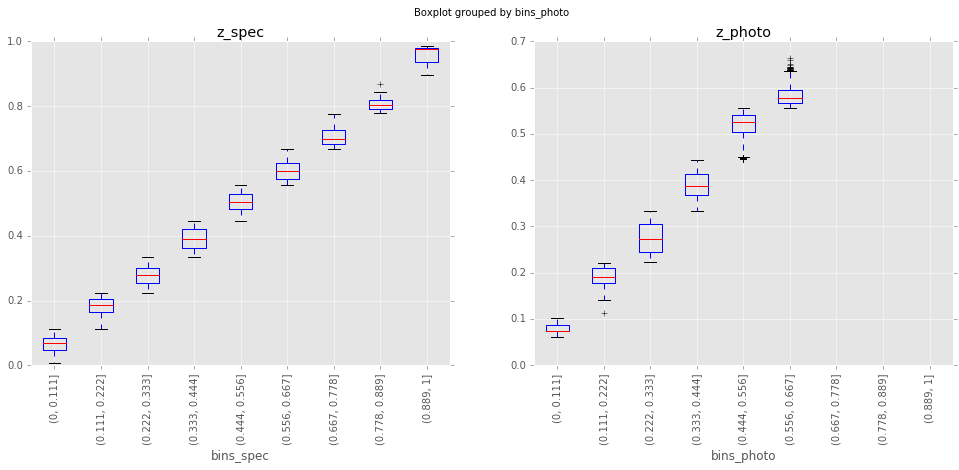

In [8]:
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16,6)
plt.style.use('ggplot')

fig,axs = plt.subplots(nrows=1,ncols=2)


#df_mod['bins_spec_x'] = pd.cut(df_mod['z_photo'],xp_bins,labels=[ '{:2.3f}'.format(s) for s in _b ])
#df_mod['bins_spec_x'] = pd.cut(df_mod['z_spec'],xs_bins,precision=3)
df_mod.boxplot(column='z_spec',by='bins_spec',ax=axs[0])
df_mod.boxplot(column='z_photo',by='bins_photo',ax=axs[1])

plt.setp(axs[0].xaxis.get_majorticklabels(),rotation=90)
plt.setp(axs[1].xaxis.get_majorticklabels(),rotation=90)
plt.show()

In [9]:
from bokeh import mpl

from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8,4)
#plt.style.use('ggplot')

#fig,axs = plt.subplots(nrows=1,ncols=2)

key1 = 'bins_spec'
grp_spec = df_mod.groupby(key1)
transformed_spec = grp_spec.transform(lambda x:x-x.mean())
transformed_spec[key1] = df_mod[key1]
transformed_spec.boxplot(column='z_spec',by=key1)
p1 = mpl.to_bokeh()

key2 = 'bins_photo'
grp_photo = df_mod.groupby(key2)
transformed_photo = grp_photo.transform(lambda x:x-x.mean())
transformed_photo[key2] = df_mod[key2]
transformed_photo.boxplot(column='z_photo',by=key2)
p2 = mpl.to_bokeh()

#plt.setp(axs[0].xaxis.get_majorticklabels(),rotation=90)
#plt.setp(axs[1].xaxis.get_majorticklabels(),rotation=90)
#plt.show()
show(gridplot([[p1],[p2]]))

## Building more-or-less manually the boxplot

Since the boxplot is presenting some problems, I sould try now to draw its elements. To shortcut the process I'll use the _pandas.DataFrame.describe()_ quantities.

In [56]:
def boxplot(df,column,by,mean=True):
    if mean:
        df['mean'] = df.groupby(by)[column].transform(lambda x:x-x.mean())
    groups = df.groupby(by)
    if mean:
        groups = groups['mean']
    else:
        groups = groups[column]

    # Generate some synthetic time series for six different categories
    cats = [ s for s,g in groups ]

    # Find the quartiles and IQR foor each category
    q1 = groups.quantile(q=0.25)
    q2 = groups.quantile(q=0.5)
    q3 = groups.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr

    # find the outliers for each category
    def outliers(group):
        cat = group.name
        #return group[(group.z_spec > upper.loc[cat][0]) | (group.z_spec < lower.loc[cat][0])]['z_spec']
        return group[(group > upper.loc[cat][0]) | (group < lower.loc[cat][0])]
    out = groups.apply(outliers).dropna()

    # Prepare outlier data for plotting, we need coordinate for every outlier.
    outx = []
    outy = []
    for cat in cats:
        # only add outliers if they exist
        if not out.loc[cat].empty:
            for value in out[cat]:
                outx.append(cat)
                outy.append(value)

    p = figure(title="", x_range=cats)

    # If no outliers, shrink lengths of stems to be no longer than the minimums or maximums
    qmin = groups.quantile(q=0.00)
    qmax = groups.quantile(q=1.00)
    #upper.z_spec = [ min([x,y]) for (x,y) in zip(list(qmax.iloc[:,0]),upper.z_spec) ]
    #lower.z_spec = [ max([x,y]) for (x,y) in zip(list(qmin.iloc[:,0]),lower.z_spec) ]
    upper = [ min([x,y]) for (x,y) in zip(qmax,upper) ]
    lower = [ max([x,y]) for (x,y) in zip(qmin,lower) ]

    # stems
    #p.segment(cats, upper.z_spec, cats, q3.z_spec, line_width=2, line_color="black")
    #p.segment(cats, lower.z_spec, cats, q1.z_spec, line_width=2, line_color="black")
    p.segment(cats, upper, cats, q3, line_width=2, line_color="black")
    p.segment(cats, lower, cats, q1, line_width=2, line_color="black")

    # boxes
    #p.rect(cats, (q3.z_spec+q2.z_spec)/2, 0.7, q3.z_spec-q2.z_spec,
    #    fill_color="#E08E79", line_width=2, line_color="black")
    #p.rect(cats, (q2.z_spec+q1.z_spec)/2, 0.7, q2.z_spec-q1.z_spec,
    #    fill_color="#3B8686", line_width=2, line_color="black")
    p.rect(cats, (q3+q2)/2, 0.5, q3-q2,    fill_color="#E08E79", line_width=2, line_color="black")
    p.rect(cats, (q2+q1)/2, 0.5, q2-q1,    fill_color="#3B8686", line_width=2, line_color="black")

    # whiskers (almost-0 height rects simpler than segments)
    #p.rect(cats, lower.z_spec, 0.2, 0.01, line_color="black")
    #p.rect(cats, upper.z_spec, 0.2, 0.01, line_color="black")
    p.rect(cats, lower, 0.2, 0.01, line_color="black")
    p.rect(cats, upper, 0.2, 0.01, line_color="black")

    # outliers
    p.circle(outx, outy, size=6, color="#F38630", fill_alpha=0.6)

#    p.grid.grid_line_width = 2
#    p.grid.grid_line_alpha = 0.5
    p.xgrid.grid_line_color = None
#    p.ygrid.grid_line_color = "gray"
    p.ygrid.minor_grid_line_color = 'gray'
    p.ygrid.minor_grid_line_alpha = 0.5
    p.ygrid.minor_grid_line_dash = 'dashed'

    p.xaxis.major_label_text_font_size="12pt"
    p.xaxis.major_label_orientation = -3.14/2
    
    p.xaxis.axis_label = by
    p.yaxis.axis_label = column if not mean else column + ' (0-mean)'
    
    return p

p_boxplot = boxplot(df_mod,column='z_spec',by='bins_spec')
show(p_boxplot)